# Alternativas para migrar packages / procedimientos almacenados a HDFS


## Librería HPL / SQL

Traductor de codigo SQL a Apache Hive y Microsoft SQL Server, o  Transact-SQL en Oracle, Cloudera Impala o Amazon Redshift.
- Ver: http://www.hplsql.org/start
```
   wget http://www.hplsql.org/downloads/hplsql-0.3.31.tar.gz
    gunzip hplsql-0.3.31.tar.gz 
    tar -xvf hplsql-0.3.31.tar 
    cd hplsql-0.3.31
    export HADOOP_CLASSPATH=`hadoop classpath`
    ./hplsql --version
    ./hplsql -e "select * from employees"
```
><p>It's not included with Hive 1.1.0 (CDH 5's version of Hive), but is downloadable and usable as a separate package. Note that it's helpful for porting, but it's not optimized like Oracle PL/SQL would be when run in an Oracle DB, or like a Spark job would be when run on a cluster.</p>


## Big Data Oracle

Try using “Oracle Big Data SQL” in case your legacy DB is Oracle. It works like a charm and you will be able to execute PLSQL queries and stored procedures on Hive using it. This is the approach which I took.
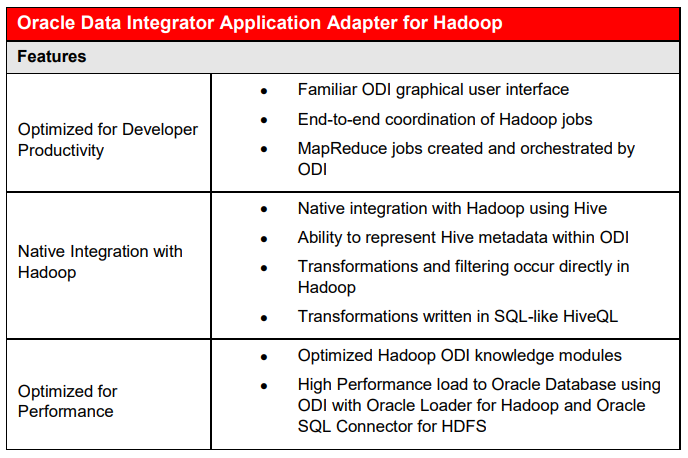

- oracle integrador 
http://www.oracle.com/us/products/middleware/data-integration/hadoop/overview/index.html

https://www.quora.com/How-do-I-replace-Oracle-PL-SQL-application-with-Big-data-tools-like-Hive-and-Spark


## Uso de Vistas

Almacenadas en la BD

##  UDF - Funciones definidas por usuario
Estas realmente no son SP  pero permiten definir la logica en java.

```
 protected ResultSet fetchDataFromJdbc(String storedProc) {
   Connection connection;
   CallableStatement statement;

   try {
     Class.forName("my.db.Driver");

     connection = DriverManager.getConnection("url","user","pass");

     statement = connection.prepareCall(storedProc);
     statement.registerOutParameter(1, "outValue");
     statement.executeQuery();

     return (ResultSet) statement.getObject(1);
   } catch (Exception e) {
         e.printStackTrace();
         log.error(e.getMessage());
   }

 throw new IllegalStateException("Results should have returned.");
}
```
https://stackoverflow.com/questions/46735996/convert-oracle-stored-procedure-to-hive-or-spark



## Carga desde archivos

Esta opcion permite cargar los achivos sql con java y enviarlos a Hive para completar los parametros de entrada.
https://stackoverflow.com/questions/46735996/convert-oracle-stored-procedure-to-hive-or-spark